# Installing Dataset

In [72]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rohanrao/nifty50-stock-market-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/nifty50-stock-market-data


In [73]:
! cp -r /kaggle/input/nifty50-stock-market-data/TATAMOTORS.csv .

# Imports

In [1]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

ModuleNotFoundError: No module named 'matplotlib'

# Load the data 

In [1]:
df = pd.read_csv('TATAMOTORS.csv', parse_dates=['Date'], index_col='Date')
df = df['Close']
df.head()

NameError: name 'pd' is not defined

# plot the dataset

<ipython-input-76-374760030>:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


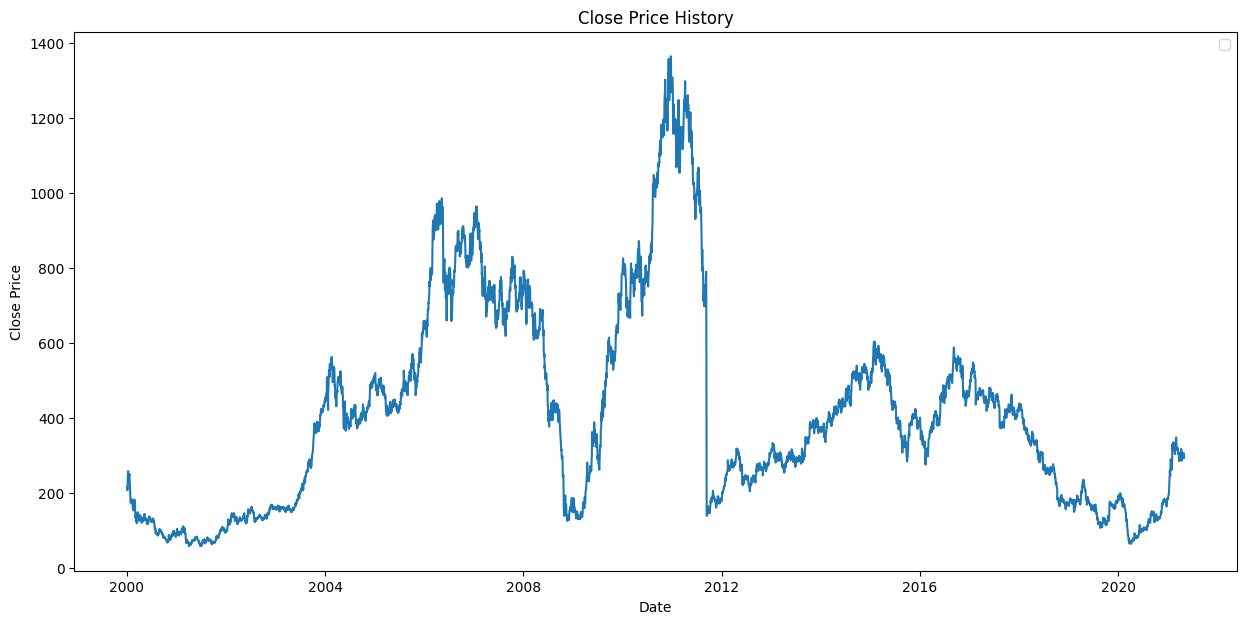

In [ ]:
plt.figure(figsize=(15, 7))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# Pre processing function   


In [ ]:
def pre_processing(df,column='Close', days_ahead=1, window_size=10, test_split=0.2):
  df = df.copy()

  df['target'] = df[column].shift(-days_ahead)  #  shift the days_ahead to the current_date as a new column 'target'
  df.dropna(inplace=True) # Removes rows with NaN values in 'target' (due to shifting)

  scaler = MinMaxScaler()  # scale the values from [0, 1]
  scaled = scaler.fit_transform(df[[column, 'target']]) # transform the entire df to [0, 1]
  # print(scaled.shape)
  
  X, Y = [], [] # split the df 

  """
  scaled = [colse, target]  shape = (len, 2, 1)

  to transfrom to 

  X = [[close]] shape = (len, window_size, 1)

  Y = [target] shape = (len, )
  """

  for i in range(len(scaled) - window_size): 
    X.append(scaled[i:i+window_size, 0])  # for each row to add i + window_size values 
    Y.append(scaled[i+window_size, 1])  # for each row get the target value 

  X, Y = np.array(X), np.array(Y) # transform it to np array
  X = X.reshape(X.shape[0], X.shape[1], 1) # reshape the np array to fit the input for the model

  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_split, shuffle=False)  # split the values from x, y as train test as 80%, 20 %

  # print(x_train.shape, x_test.shape, y_train.shape, y_test.shape) 

  return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = pre_processor(df, column='Close', days_ahead=10, window_size=10, test_split=0.2)

(5296, 2)
(4228, 10, 1) (1058, 10, 1) (4228,) (1058,)


# Modeling

In [ ]:
model = Sequential([
    # input layer shape (window_size, 1)
    LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    LSTM(32, return_sequences=False), # additional layers for high accuracy
    Dense(32, activation='relu'), 
    Dense(1) # ouput layer return the close value for respected days
])
model.compile(optimizer='adam', loss='mse', metrics=['mse']) # compiler using adam optimizer and loss as mean square error
model.summary() # summary to print the model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,401 (118.75 KB)

 Trainable params: 30,401 (118.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test)) # fit the training dataset to the model

# plot the MeanSquaredError through epochs  

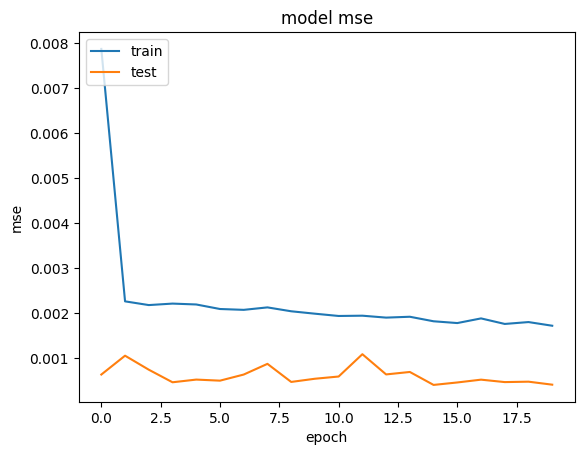

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# predict the model with test set

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


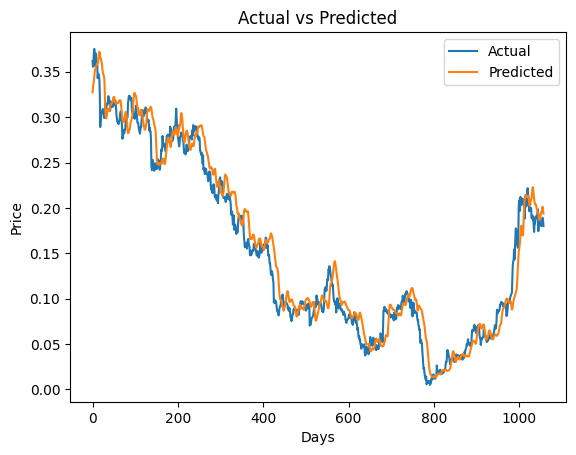

In [ ]:
y_pred = model.predict(x_test)

plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend()
plt.show()

# MSE and MAE calculations

In [ ]:
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}')

RMSE: 0.02, MAE: 0.02
